In [3]:
# %pip install datasets transformers[torch]

In [4]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import warnings
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from datasets import Dataset
# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv("/content/flipkart_reviews_data.csv")

In [6]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [7]:
print(df.shape)

(205052, 6)


In [8]:
df['Sentiment'].value_counts()

Sentiment
positive    166581
negative     28232
neutral      10239
Name: count, dtype: int64

In [9]:
sentiment_distribution = df['Sentiment'].value_counts()

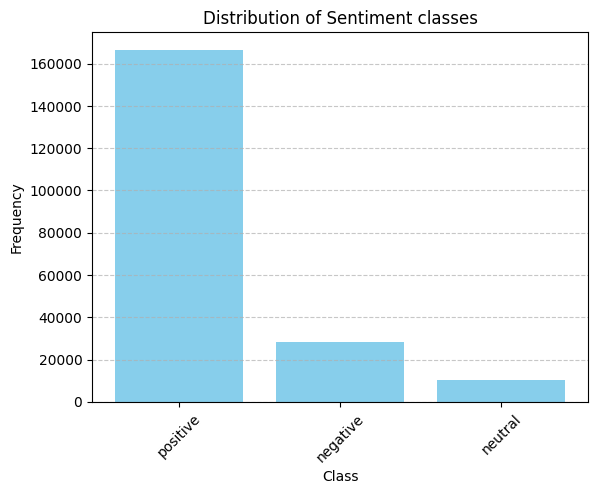

In [10]:
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Distribution of Sentiment classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
df.isnull().sum()

product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64

In [12]:
df.dropna(subset=['Summary'],inplace=True, axis=0)

In [13]:
df.isnull().sum()

product_name         0
product_price        0
Rate                 0
Review           24662
Summary              0
Sentiment            0
dtype: int64

In [14]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords and apply Porter Stemmer
    processed_words = [
        stemmer.stem(word) for word in words if word.isalnum() and word not in stop_words
    ]

    # Join words back into a single string
    processed_text = ' '.join(processed_words)

    return processed_text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
df['summary_cleaned']=df['Summary'].apply(preprocess_text)

In [16]:
min_class_count = df['Sentiment'].value_counts().min()

# Resample each class to the same count
df_balanced= df.groupby('Sentiment').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['Sentiment'].value_counts())

Sentiment
negative    10234
neutral     10234
positive    10234
Name: count, dtype: int64


In [17]:
encoding={val:key for key,val in enumerate(sorted(df_balanced['Sentiment'].unique().tolist()))}

In [18]:
label_id=pd.DataFrame(encoding.items(),columns=['labels','classes'])

In [19]:
label_id.to_csv("label_to_id.csv",index=False)

In [20]:
df_balanced['sentiment_class'] =df_balanced['Sentiment'].map(encoding)

In [21]:
df_balanced.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,summary_cleaned,sentiment_class
0,Microtek MTKAA70H Microtek EB 700 Square Wave ...,4199,1,don't waste your money,worst product i will receive damage product la...,negative,worst product receiv damag product late delive...,0
1,MOTOROLA 8 kg Smart Wi-Fi Enabled Inverter Tec...,16990,1,horrible,such a bad product and service is also bad,negative,bad product servic also bad,0
2,I Kall IK22 40 W Bluetooth Home Theatre??????(...,1499,1,hated it!,very worst i bought one only one month working...,negative,worst bought one one month work work sad,0
3,Men Black Sandal,299,1,NaN,size not good,negative,size good,0
4,"POCO C31 (Royal Blue, 64 GB)?ÐÒÐÒ?ÐÒÐÒ...",7499,2,could be way better,camera is not good,negative,camera good,0


In [22]:
dataset = Dataset.from_pandas(df_balanced)

# Split the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

In [23]:
dataset

Dataset({
    features: ['product_name', 'product_price', 'Rate', 'Review', 'Summary', 'Sentiment', 'summary_cleaned', 'sentiment_class'],
    num_rows: 30702
})

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 400  # Maximum length of input tokens

def tokenize_function(examples):
    return tokenizer(
        examples['summary_cleaned'],
        padding='max_length',
        truncation=True,
        max_length=max_len
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/21491 [00:00<?, ? examples/s]

Map:   0%|          | 0/9211 [00:00<?, ? examples/s]

In [25]:
# Rename 'sentiment_class' to 'labels' for compatibility with Trainer API
train_dataset = train_dataset.rename_column('sentiment_class', 'labels')
val_dataset = val_dataset.rename_column('sentiment_class', 'labels')

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
)


In [27]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [30]:
trainer.train()

Step,Training Loss
1000,0.775400
2000,0.568000
3000,0.541600
4000,0.499400
5000,0.492700
6000,0.448600
7000,0.434300
8000,0.433600
9000,0.377800
10000,0.394300


TrainOutput(global_step=10748, training_loss=0.4897372774976667, metrics={'train_runtime': 6356.058, 'train_samples_per_second': 13.525, 'train_steps_per_second': 1.691, 'total_flos': 1.76705326887264e+16, 'train_loss': 0.4897372774976667, 'epoch': 4.0})

In [31]:
trainer.evaluate()

{'eval_loss': 0.6199206113815308,
 'eval_accuracy': 0.7990446205623711,
 'eval_precision': 0.798574782965608,
 'eval_recall': 0.7990446205623711,
 'eval_f1': 0.7979862752119665,
 'eval_runtime': 209.4548,
 'eval_samples_per_second': 43.976,
 'eval_steps_per_second': 5.5,
 'epoch': 4.0}

In [32]:
model_save_path = './fine_tuned_bert'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [33]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the model and tokenizer
model_save_path = '/content/fine_tuned_bert'
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

In [34]:
label_id=pd.read_csv('/content/label_to_id.csv')
label_id=label_id[['classes','labels']]
labels_to_id=dict(label_id.values)

In [36]:
import torch
input_review = "the shirt was torn"
token=tokenizer(input_review,return_tensors='pt')

with torch.no_grad():
    outputs = model(**token)
    logits = outputs.logits

# Optionally apply softmax and determine predicted class
probabilities = torch.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1).item()
print(predicted_class)
# Print predicted class index
print("Predicted Class Index:", predicted_class)

print(labels_to_id[predicted_class])

0
Predicted Class Index: 0
negative
